# Exploratory Data Analysis of Hacker News Articles (02/04 - 02/06)
Tae Emmerson | Feb. 06 2026

This notebook is exploring the collected articles from Hacker News and finding the features that correlate with articles who ranked and stayed within the top 30 articles after 24 hours. Concretely:
- Features are collected at 30 minutes (domain, URLs, timestamps, comments)
- Labels are created in Snowflake based on whether the article made its way to the Top 30 articles after 24 hours

__End Modeling Goal:__ *Predict which of the articles in a cohort of 500 will be ranked in the top 30 after 24 hours.*

This will also prototype a TF-IDF matrix pipeline and webpage retrieval using numpy and pandas.

In [364]:
import os
import re
import numpy as np
import pandas as pd
import snowflake.connector
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer

from dotenv import load_dotenv

load_dotenv()

True

## Pulling Data from Snowflake

The data was stored locally in SQLite to handle crashes and file conflicts, but it is converted to a CSV and uploaded to Snowflake (not compatible with SQLite) to create the labels and create features.

In [ ]:
conn = snowflake.connector.connect(
    user=os.environ['SF_USERNAME'],
    password=os.environ['SF_PASSWORD'],   
    account=os.environ['SF_ACCOUNT'],
    warehouse="HN_WH",
    database="HN_DB",
    schema="PUBLIC",
)

df = pd.read_sql("""
    SELECT *
    FROM TRAIN_DATASET_V
""", conn)

In [105]:
print(df.shape)
df.head(2).T

(1028, 23)


,0,1
STORY_ID,46889008,46893411
CREATED_TS,1770227366,1770247583
CREATED_TS_UTC,2026-02-04 17:49:26,2026-02-04 23:26:23
AUTHOR,jart,andsoitis
TITLE,The Great Unwind,Why more companies are recognizing the benefit...
URL,https://occupywallst.com/yen,https://longevity.stanford.edu/why-more-compan...
DOMAIN,occupywallst.com,longevity.stanford.edu
SCORE_30M,124,3
COMMENTS_30M,67.0,0.0
KIDS_COUNT_30M,18,0


In [109]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 1028 entries, 0 to 1027
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   STORY_ID                1028 non-null   int64         
 1   CREATED_TS              1028 non-null   int64         
 2   CREATED_TS_UTC          1028 non-null   datetime64[us]
 3   AUTHOR                  1028 non-null   str           
 4   TITLE                   1028 non-null   str           
 5   URL                     958 non-null    str           
 6   DOMAIN                  958 non-null    str           
 7   SCORE_30M               1028 non-null   int64         
 8   COMMENTS_30M            1023 non-null   float64       
 9   KIDS_COUNT_30M          1028 non-null   int64         
 10  TITLE_LEN               1028 non-null   int64         
 11  IS_SHOW_HN              1028 non-null   int64         
 12  IS_ASK_HN               1028 non-null   int64         
 13 

Let's check for label imbalance and the presence of NAs:

In [81]:
df.groupby("Y_TOP30_DAILY").agg(
    total=("STORY_ID", "size"),
    total_na=("URL", lambda x: x.isna().sum())

).assign(
    total_prop=lambda x: x['total'] / x['total'].sum(),
    na_prop=lambda x: x['total_na'] / x['total_na'].sum()
).round(3)

,total,total_na,total_prop,na_prop
Y_TOP30_DAILY,,,,
0,983,69,0.956,0.986
1,45,1,0.044,0.014


It looks like we are missing some URLs (causing a missing domain) and comments. Most of these are for our large negative class, but we will add a missingness indicator when modeling. This feature may not be very useful right now as it will be extremely sparse.

In [66]:
print(df['AUTHOR'].value_counts(normalize=True)[:5])
print(df['AUTHOR'].value_counts(normalize=True)[-5:])

AUTHOR
tosh            0.018482
speckx          0.013619
mooreds         0.012646
todsacerdoti    0.011673
rbanffy         0.008755
Name: proportion, dtype: float64
AUTHOR
knightron0      0.000973
blindnomore     0.000973
Hariom5         0.000973
jesstemporal    0.000973
sicher          0.000973
Name: proportion, dtype: float64


Intrestingly, we must have some repeat authors for some articles. I wonder if this correlates with the top ranked articles?

In [101]:
df.merge(
    df['AUTHOR'].value_counts(normalize=True).reset_index(), 
    how='left', on='AUTHOR'
).assign(
    AUTHOR=lambda x: x['AUTHOR'].astype('category').cat.codes
    )[['AUTHOR', 'Y_TOP30_DAILY', 'proportion']].corr()

,AUTHOR,Y_TOP30_DAILY,proportion
AUTHOR,1.000000,-0.06541,0.227107
Y_TOP30_DAILY,-0.065410,1.00000,-0.023860
proportion,0.227107,-0.02386,1.000000


There doesn't seem to be a significant correlation between author, author post proportions, or the outcome of articles. However, more data and rigorous feature engineering may change this in future studies.

Let's do a general look at the correlation between numeric values. Since there are a lot, I'll use a heatmap from Seaborn to visualize it.

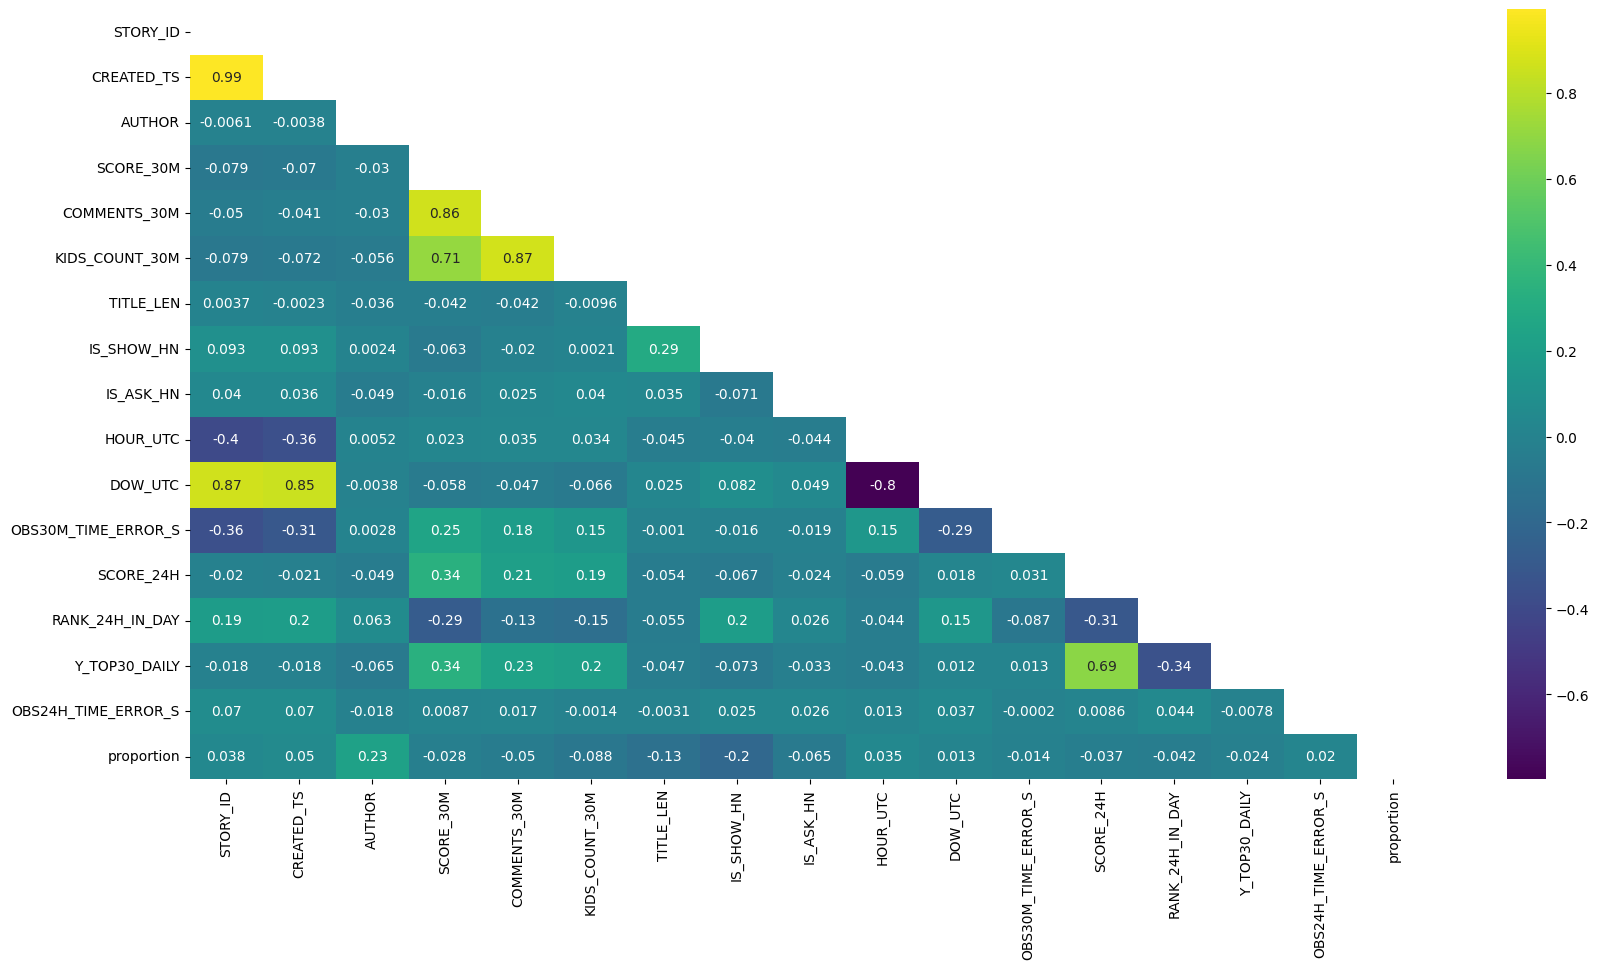

In [137]:
corr = df.merge(
    df['AUTHOR'].value_counts(normalize=True).reset_index(), 
    how='left', on='AUTHOR'
).assign(
    AUTHOR=lambda x: x['AUTHOR'].astype('category').cat.codes
    ).select_dtypes('number').corr()

mask = np.triu(np.ones_like(corr), k=0) # mask to lower half for easier visualization

plt.figure(figsize=(20,10))
ax = sns.heatmap(
    data=corr,
    mask=mask,
    annot=True,
    cmap='viridis'
)
plt.show()

Interestingly, the day of the week (DOW_UTC) is negatively correlated with the hour at which the posts are made. The score/rank at 24 hours also does not perfectly correlate with our label, which is to be expected due to our label being influenced by other posts.

Our key predictive features look solid: the score, number of comments, and number of descendants all correlate with our label. However, there is high multicolinearity between them, which is important to consider when training our model. 

Importantly, we also do not include some key features here, such as the title and domain. We will need to convert these to either an embedding or frequency counts. We can do this by creating a variable for different words counts, or we can use a TF-IDF matrix.

Let's take a closer look at our main features collected at 30 minutes.

In [220]:
main_features = ["SCORE_30M", "COMMENTS_30M", "KIDS_COUNT_30M"]
df[main_features + ['Y_TOP30_DAILY']].groupby('Y_TOP30_DAILY').describe().round(4).T

Y_TOP30_DAILY                0         1
SCORE_30M      count  983.0000   45.0000
               mean     1.8067    9.7556
               std      1.7318   20.2419
               min      1.0000    1.0000
               25%      1.0000    2.0000
               50%      1.0000    3.0000
               75%      2.0000    6.0000
               max     26.0000  124.0000
COMMENTS_30M   count  978.0000   45.0000
               mean     0.3671    3.3111
               std      0.9857   11.3214
               min      0.0000    0.0000
               25%      0.0000    0.0000
               50%      0.0000    0.0000
               75%      1.0000    1.0000
               max     19.0000   67.0000
KIDS_COUNT_30M count  983.0000   45.0000
               mean     0.3774    1.4667
               std      0.7731    3.6407
               min      0.0000    0.0000
               25%      0.0000    0.0000
               50%      0.0000    0.0000
               75%      1.0000    1.0000
               max     13.0000   18.0000

Posts that rank in the top 30 after 24 hours seem to have a higher average across all of our features, which intuitively makes sense. Posts that have more impressions and interactions earlier are likely to do better later on as well. However, these aren't necessarily significant due to the high standard deviation, partially caused by our class imbalance and small sample size.

Let's visualize the distributions:

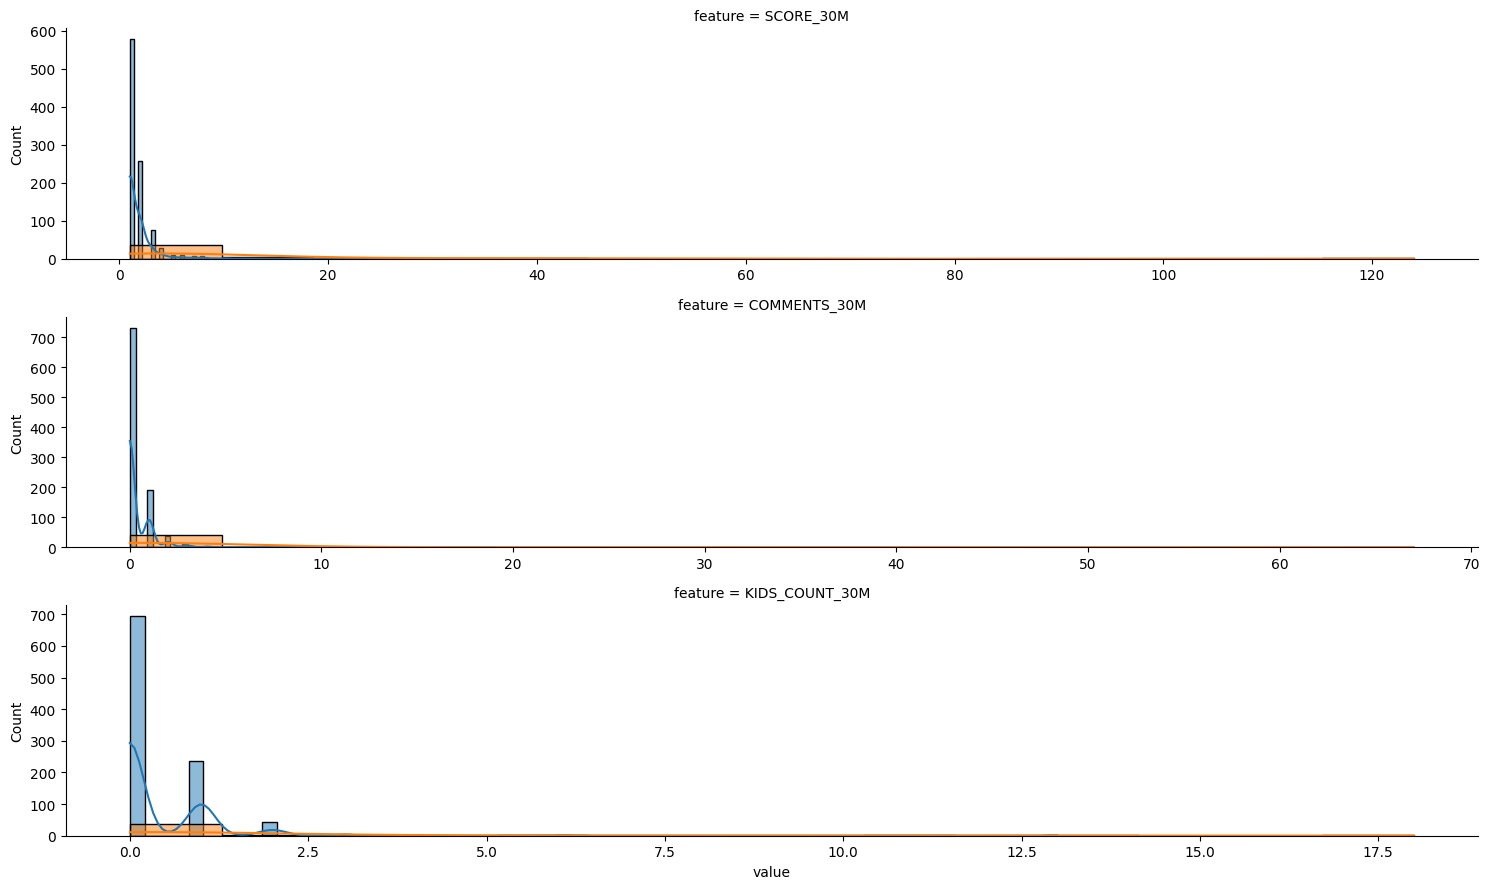

In [213]:
g = sns.FacetGrid(
    df.melt(
    id_vars=["Y_TOP30_DAILY"],
    value_vars=main_features,
    var_name="feature",
    value_name="value",
),
row="feature",
hue='Y_TOP30_DAILY',
height=3,
aspect=5,
sharey=False,
sharex=False
)
g.map(sns.histplot, 'value', kde=True, multiple='layer')

Our collected features are highly skewed, but that is to be expected! The vast majority of our datapoints won't have any significant signals during the first 30 minutes, so they are clustered around zero. We can fix this before modelling by log transforming our data. Importantly, because we have zero values for the comments and children, we must add 1 before log transforming.

In [259]:
df['log_SCORE_30M'] = np.log(df['SCORE_30M'] + 1)
df['log_COMMENTS_30M'] = np.log(df['COMMENTS_30M'] + 1)
df['log_KIDS_COUNT_30M'] = np.log(df['KIDS_COUNT_30M'] + 1)
print(df.shape) # 3 new features since we're not overwriting the old ones

# we can revert the features back if we want
all((np.exp(df['log_KIDS_COUNT_30M']) - 1).round(1) == df['KIDS_COUNT_30M'])

(1028, 26)


True

Let's replot our main features individually to get a better look at the distributions. Since we have imbalanced data, I'm going to plot the densities this time to look at the features w.r.t the sample size.

In [319]:
def plot_density(variable):
    plt.figure(figsize=(20,5))
    ax = sns.kdeplot(
        df,
        x=variable,
        hue = 'Y_TOP30_DAILY', 
        multiple='layer', 
        common_norm=False
    )
    ax.vlines(x=df.groupby('Y_TOP30_DAILY')[variable].mean(), ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], linestyles='--', colors=['darkblue', 'darkorange'])
    plt.show()

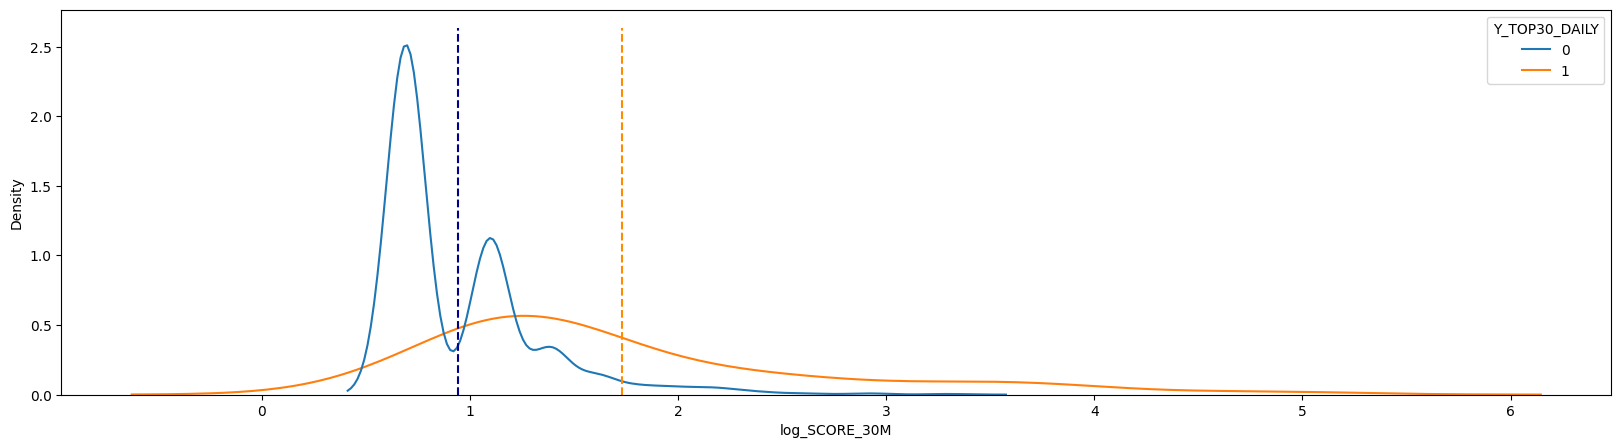

In [320]:
plot_density('log_SCORE_30M')

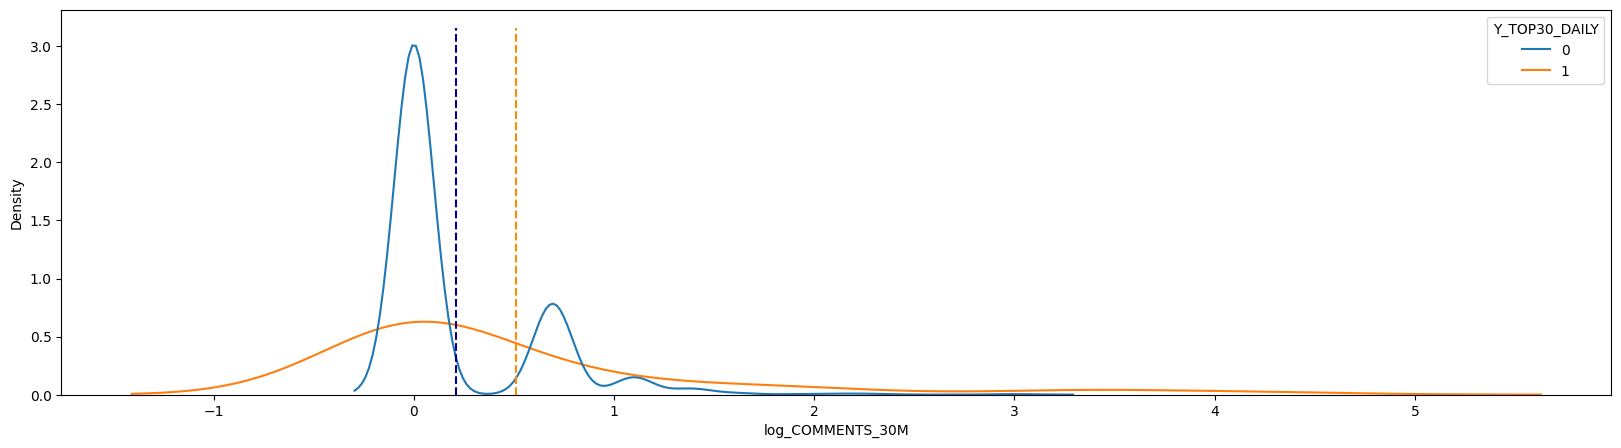

In [321]:
plot_density('log_COMMENTS_30M')

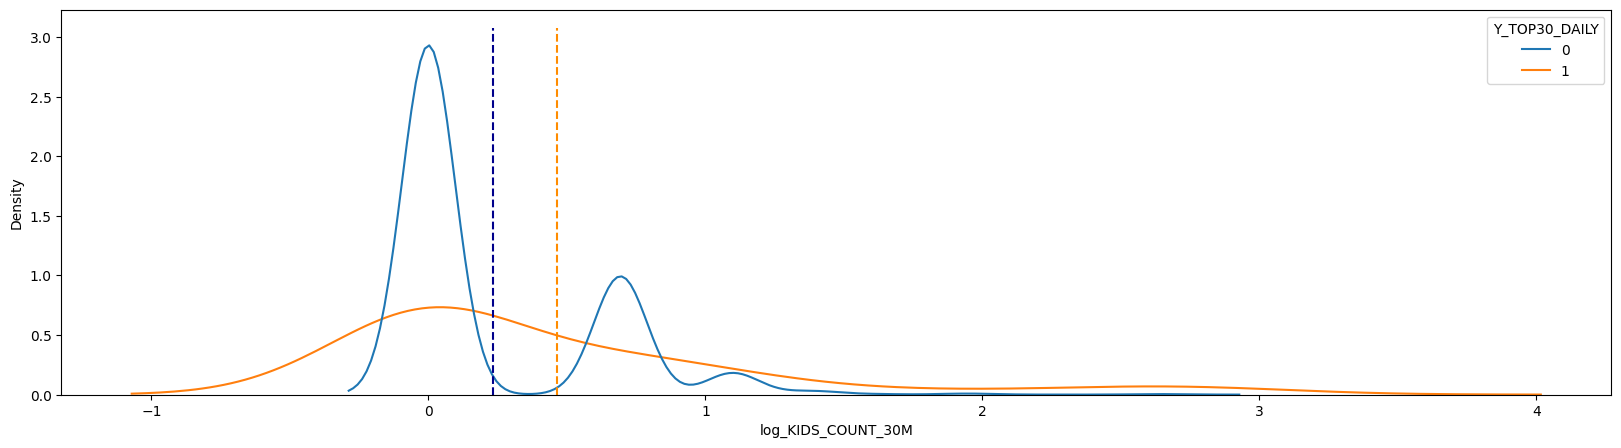

In [322]:
plot_density('log_KIDS_COUNT_30M')

It is much clearer that the distributions of our main predictors are different, even with our small sample size. For our positive labeled posts, the right tail is a little bit higher than the non-positive posts. This is further seen with our mean, though the median appears similar. We will have to verify this trend with more data as it comes in.

### Dealing with Strings

A straightforward approach to handling the titles would be to construct a vocabulary from them and create a list of new features indicating the count of each word. This is a naive approach and generally doesn't work as well with larger datasets. But let's try it on our small dataset.

In [479]:
bow = df['TITLE'].str.lower().str.findall(r'\b[a-zA-Z]+\b').explode()
word_counts = pd.get_dummies(bow).groupby(level=0).sum()
print(word_counts.shape)
print(word_counts['the'].head())

(1028, 3355)
0    1
1    1
2    0
3    1
4    1
Name: the, dtype: int64


We have our word counts, but do any of these correlate with our labels?

In [524]:
word_counts.corrwith(df['Y_TOP30_DAILY']).sort_values()[-20:].round(4)

tumbles       0.1458
frontier      0.1458
gains         0.1458
performers    0.1458
detention     0.1458
hide          0.1458
phones        0.1458
child         0.1458
mega          0.1458
bitcoin       0.1458
warehouse     0.1458
nothing       0.1458
rarely        0.1458
jammer        0.1458
launch        0.1458
factbook      0.1557
leaked        0.1647
ice           0.1901
responds      0.2064
middle        0.2064
dtype: float64

In [498]:
print(f"5 Most Negatively Correlated:\n{word_counts.corrwith(df['Y_TOP30_DAILY']).sort_values()[:5].round(4)}", end="\n\n")
print(f"5 Most Positively Correlated:\n{word_counts.corrwith(df['Y_TOP30_DAILY']).sort_values()[-5:].round(4)}")

5 Most Negatively Correlated:
show   -0.0747
hn     -0.0723
ai     -0.0609
and    -0.0487
with   -0.0479
dtype: float64

5 Most Positively Correlated:
factbook    0.1557
leaked      0.1647
ice         0.1901
responds    0.2064
middle      0.2064
dtype: float64


Interesting! We see that there are certainly a few words that correlate somewhat strongly with our labels. If we had more data, we could incorporate more factors like capitalization and special characters, but I'll keep it somewhat low dimensional. To reduce the dimensionality, we could reduce our vocabulary based on strong positive and negative correlations and drop less important words.

At the time of writing (02/06), "ice" and "leaked" being the 3rd and 4th most correlated words aren't surprising given the political context. I'm curious how "ice" being in the title might affect the distribution of our labels.

In [515]:
ice_df = df.copy(deep=True)
ice_df['ice'] = word_counts['ice']

In [521]:
ice_df.groupby('ice')['Y_TOP30_DAILY'].mean()

ice
0    0.041056
1    0.600000
Name: Y_TOP30_DAILY, dtype: float64

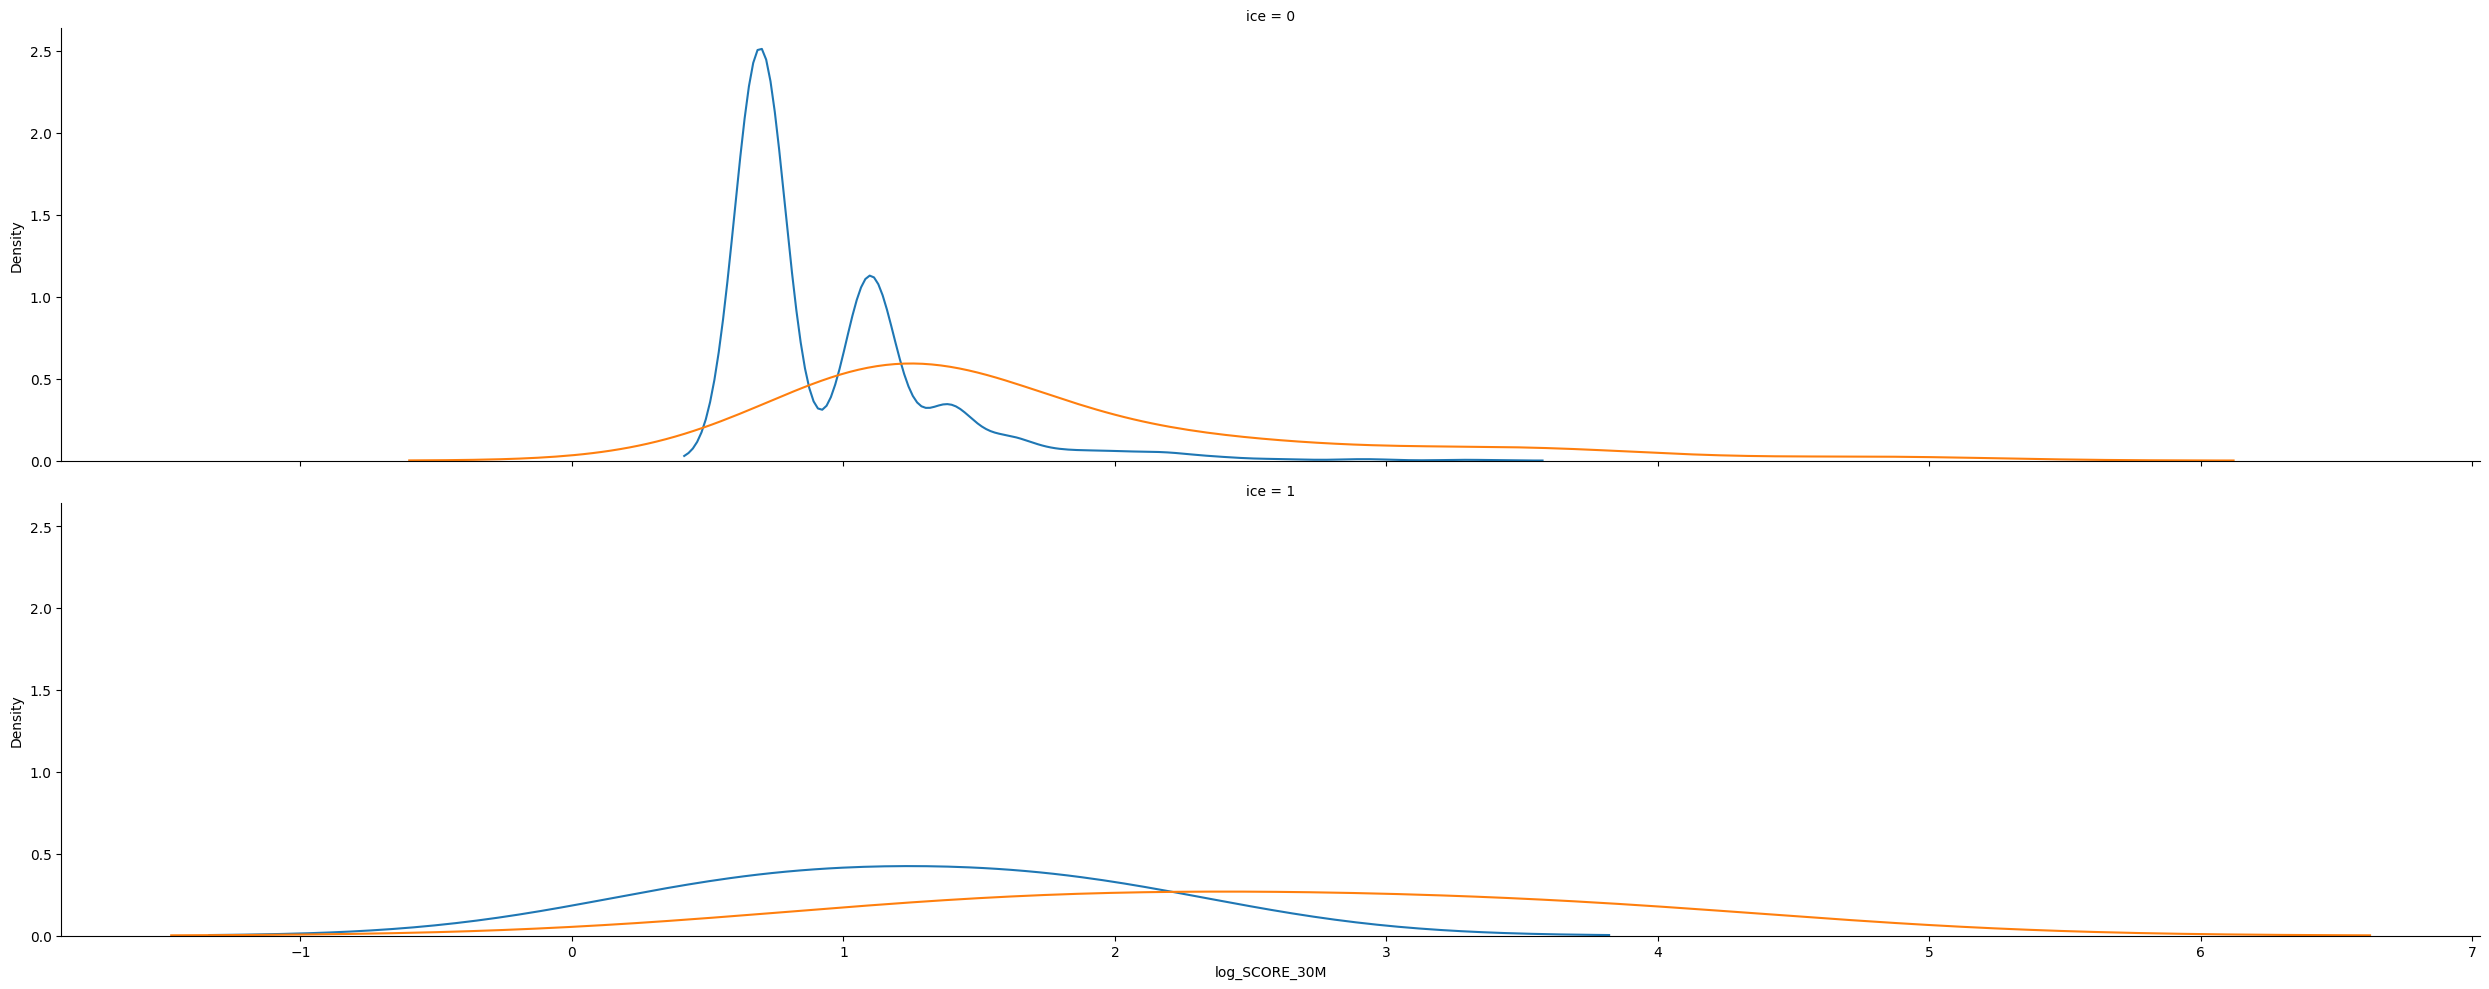

In [522]:
g = sns.FacetGrid(ice_df, hue='Y_TOP30_DAILY', row='ice', height=5, aspect=5, sharex=True)
g.map(sns.kdeplot, 'log_SCORE_30M')

### TF-IDF Conversion

Using scikit-learn's TF-IDF transformer is more common in practice.

In [595]:
tfidf = TfidfVectorizer(
    max_features=50000,
    ngram_range=(1, 2),
    min_df=5, # must occur in at least 5 titles (documents)
    max_df=0.50, # cannot occur in more than 70% of them
    lowercase=True,
    strip_accents='unicode'
)
titles = tfidf.fit_transform(df['TITLE'])
titles = pd.DataFrame(titles.toarray(), columns=tfidf.get_feature_names_out()) # generally don't have to do this for modeling

In [596]:
i = 10
print(f"{i} Most Negatively Correlated:\n{titles.corrwith(df['Y_TOP30_DAILY']).sort_values()[:i].round(4)}", end="\n\n")
print(f"{i} Most Positively Correlated:\n{titles.corrwith(df['Y_TOP30_DAILY']).sort_values()[-i:].round(4)}")

10 Most Negatively Correlated:
show      -0.0661
show hn   -0.0650
ai        -0.0597
hn        -0.0595
and       -0.0510
with      -0.0485
video     -0.0399
an        -0.0391
that      -0.0348
agents    -0.0325
dtype: float64

10 Most Positively Correlated:
when              0.1035
sam               0.1144
sam altman        0.1144
cia               0.1148
ve                0.1333
hardware          0.1345
the world         0.1593
world factbook    0.1643
factbook          0.1643
ice               0.1831
dtype: float64


In [632]:
from sklearn.linear_model import LogisticRegression # use optuna
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, average_precision_score

In [631]:
train_df = df.dropna()

In [ ]:
train_df.select_dtypes

In [646]:
numeric_columns = train_df[main_features].merge(titles, left_index=True, right_index=True).select_dtypes("number").columns
pipe = Pipeline(steps=[
    ("preprocess", ColumnTransformer(transformers=[
        ("numeric", Pipeline([
            ("Scaler", StandardScaler()),
            ("Imputer", SimpleImputer(strategy="median"))
        ]
        ), numeric_columns)], 
    )),
    ("model", LogisticRegression(class_weight="balanced"))
]
)

In [647]:
pipe.fit(
    train_df[main_features].merge(titles, left_index=True, right_index=True),
    train_df['Y_TOP30_DAILY']
)

train_probs = pipe.predict_proba(train_df[main_features].merge(titles, left_index=True, right_index=True))[:, 1]

In [648]:
def evaluate(targets, probs, threshold=0.5):
    labels = probs > threshold
    return {
        "accuracy": accuracy_score(targets, labels),
        "precision": precision_score(targets, labels),
        "recall": recall_score(targets, labels),
        "auprc": average_precision_score(targets, probs)
    }

In [649]:
evaluate(train_df['Y_TOP30_DAILY'], train_probs)

{'accuracy': 0.9539267015706806,
 'precision': 0.5,
 'recall': 0.9772727272727273,
 'auprc': 0.8846411304484546}